# Method paper plots

In [1]:
import sys
from pathlib import Path

# Get the current notebook's directory
notebook_dir = Path().resolve()

# Add the parent directory of the module to the Python path
sys.path.append(str(notebook_dir.parent))

In [2]:
import qnmfits
import numpy as np
import scipy
import corner
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import to_hex
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from qnmfits.spatial_mapping_functions import * 
from bayes_qnm_GP_likelihood import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
#plt.style.use("stylesheet.mplstyle")
fig_width = 246.0 * (1.0 / 72.27)
fig_height = fig_width / 1.618

colors = [
    "#395470",  # soft viridis-style blue
    "#5A7A87",  # pastel twilight blue-teal
    "#A4C9A7",  # pastel sage
    "#D3C76A",  # pastel olive
    "#E9DF83",  # slightly darker pastel yellow
]

matte_viridis = LinearSegmentedColormap.from_list('custom_colormap', colors)

In [4]:
id = "0001"

sim_main = SXS_CCE(id, lev="Lev5", radius="R2")
sim_lower = SXS_CCE(id, lev="Lev4", radius="R2")

# Align waveforms (for noise floor calcs) and put them on the same time grid 

time_shift = get_time_shift(sim_main, sim_lower)
sim_lower.zero_time = -time_shift
sim_lower.time_shift()

new_times = np.arange(sim_main.times[0], sim_main.times[-1], 0.1)
sim_main_interp = sim_interpolator(sim_main, new_times)
sim_lower_interp = sim_interpolator(sim_lower, new_times)

N_MAX = 7
T = 100

qnm_list = [(2,2,n,1) for n in np.arange(0, N_MAX+1)] #+ [(3,2,0,1), (4,2,0,1)]
spherical_modes = [(2, 2)]

# Get the true, reference values for mass and spin 

chif_mag_ref = sim_main.chif_mag
Mf_ref = sim_main.Mf

T0s = np.linspace(-25, 100, 65)

T0_REF = 17

INCLUDE_MF = True
INCLUDE_CHIF = True

### Determine mass and spin as free parameters for least-squares

In [5]:
def Mf_chif_mismatch(Mf_chif_mag_list, t0, T, spherical_modes):
    Mf, chif_mag = Mf_chif_mag_list
    best_fit = qnmfits.multimode_ringdown_fit(
                sim_main.times, sim_main.h, qnm_list, Mf, chif_mag, t0, t0_method="geq", T=T, spherical_modes=spherical_modes
                )
    return best_fit["mismatch"]

In [6]:
initial_params = (Mf_ref, chif_mag_ref)

Mf_RANGE = (Mf_ref*0.5, Mf_ref*1.5)
chif_mag_RANGE = (0.1, 0.99)
bounds = (Mf_RANGE, chif_mag_RANGE)

result = minimize(
            Mf_chif_mismatch,
            initial_params,
            args=(T0_REF, T, spherical_modes),
            method="Nelder-Mead",
            bounds=bounds,
        )

Mf_t0 = result.x[0]
chif_t0 = result.x[1] 

Mfs_chifs = np.zeros((len(T0s), 2))

for i, t0 in enumerate(T0s):

    args = (t0, T, spherical_modes)

    result = minimize(
            Mf_chif_mismatch,
            initial_params,
            args=args,
            method="Nelder-Mead",
            bounds=bounds,
        )

    Mfs_chifs[i] = result.x
    initial_params = result.x

In [7]:
notebook_dir = Path().resolve()
data_dir = notebook_dir.parent / "data"

In [8]:
# Get the main kernel parameters

with open(data_dir / 'tuned_params.pkl', 'rb') as f:
            params = pickle.load(f)

tuned_param_dict_main = params[id]

In [9]:
# Get the white noise kernel parameters 

with open(data_dir / 'param_dict_sim_lm_full.pkl', 'rb') as f:
    param_dict_sim_lm = pickle.load(f)

tuning_hyperparams_s = [0.29245605468749936]  # This value was determined in get_kernel_params_alt.ipynb

hyperparam_rule_dict_s = {
    "sigma_max": "multiply",
}

tuned_param_dict_wn = {mode: get_new_params(param_dict_sim_lm[id][mode], tuning_hyperparams_s, hyperparam_rule_dict_s) for mode in param_dict_sim_lm[id]}

### Get the fit data at a range of t0s

In [19]:
unweighted_mismatches_LS = np.zeros((len(T0s)))
weighted_mismatches_LS = np.zeros((len(T0s)))

unweighted_mismatches_WN = np.zeros((len(T0s)))
weighted_mismatches_WN = np.zeros((len(T0s)))

unweighted_mismatches_GP = np.zeros((len(T0s)))
weighted_mismatches_GP = np.zeros((len(T0s)))

unweighted_mismatches_noise = np.zeros((len(T0s)))
weighted_mismatches_noise = np.zeros((len(T0s)))

amplitudes_LS = np.zeros((len(T0s), len(qnm_list)))

ampltiudes_WN = np.zeros((len(T0s), len(qnm_list)))
amplitudes_GP = np.zeros((len(T0s), len(qnm_list)))

amplitudes_WN_percentiles = {p: np.zeros((len(T0s), len(qnm_list))) for p in [10, 25, 50, 75, 90]}
amplitudes_GP_percentiles = {p: np.zeros((len(T0s), len(qnm_list))) for p in [10, 25, 50, 75, 90]}
uw_amplitudes_GP_percentiles = {p: np.zeros((len(T0s), len(qnm_list))) for p in [10, 25, 50, 75, 90]}

significances_WN = np.zeros((len(T0s), len(qnm_list)))
significances_GP = np.zeros((len(T0s), len(qnm_list)))

for i, t0 in enumerate(T0s):

    print(f"t0 = {t0}")

    Mf = Mfs_chifs[i, 0]
    chif_mag = Mfs_chifs[i, 1]

    fit_GP = qnm_BGP_fit(
            sim_main.times,
            sim_main.h,
            qnm_list,
            Mf_ref,
            chif_mag_ref,
            t0,
            tuned_param_dict_main,
            kernel_main,
            t0_method="geq",
            T=T,
            spherical_modes=spherical_modes,
            include_chif=INCLUDE_CHIF,
            include_Mf=INCLUDE_MF,
        )
    
    fit_WN = qnm_BGP_fit(
            sim_main.times,
            sim_main.h,
            qnm_list,
            Mf_ref,
            chif_mag_ref,
            t0,
            tuned_param_dict_wn,
            kernel_s,
            t0_method="geq",
            T=T,
            spherical_modes=spherical_modes,
            include_chif=INCLUDE_CHIF,
            include_Mf=INCLUDE_MF,
        )
    
    fit_LS = qnmfits.multimode_ringdown_fit(
                        sim_main.times,
                        sim_main.h,
                        qnm_list,
                        Mf,
                        chif_mag,
                        t0,
                        T=T,
                        spherical_modes=spherical_modes,
                    )
    
    # Mismatch
    
    unweighted_mismatches_LS[i] = unweighted_mismatch(fit_LS['model'], fit_LS['data'])
    weighted_mismatches_LS[i] = weighted_mismatch(fit_LS['model'], fit_LS['data'], fit_GP['inv_noise_covariance']) 

    unweighted_mismatches_WN[i] = unweighted_mismatch(fit_WN['model'], fit_WN['data'])
    weighted_mismatches_WN[i] = weighted_mismatch(fit_WN['model'], fit_WN['data'], fit_GP['inv_noise_covariance']) 

    unweighted_mismatches_GP[i] = unweighted_mismatch(fit_GP['model'], fit_GP['data'])
    weighted_mismatches_GP[i] = weighted_mismatch(fit_GP['model'], fit_GP['data'], fit_GP['inv_noise_covariance'])

    mm_mask = (sim_main_interp.times >= t0 - 1e-9) & (sim_main_interp.times < t0+T - 1e-9)
    mm_times = sim_main_interp.times[mm_mask]
    main_data = {(2, 2): sim_main_interp.h[(2, 2)][mm_mask]}
    lower_data = {(2, 2): sim_lower_interp.h[(2, 2)][mm_mask]}
    unweighted_mismatches_noise[i] = unweighted_mismatch(main_data, lower_data)
    weighted_mismatches_noise[i] = weighted_mismatch(main_data, lower_data, fit_GP['inv_noise_covariance'])

    # Amplitude 

    amplitudes_LS[i, :] = np.abs(fit_LS['C'])
    ampltiudes_WN[i, :] = fit_WN['mean_abs_amplitude']
    amplitudes_GP[i, :] = fit_GP['mean_abs_amplitude']

    for p in [10, 25, 50, 75, 90]:
        amplitudes_WN_percentiles[p][i, :] = fit_WN["abs_amplitude_percentiles"][p]
        amplitudes_GP_percentiles[p][i, :] = fit_GP["abs_amplitude_percentiles"][p]
        uw_amplitudes_GP_percentiles[p][i, :] = fit_GP['test_abs_amplitude_percentiles'][p]

    # Significance 

    significances_WN[i, :] = get_significance_list(qnm_list, fit_WN['mean'], fit_WN['fisher_matrix']) 
    significances_GP[i, :] = get_significance_list(qnm_list, fit_GP['mean'], fit_GP['fisher_matrix'])

t0 = -25.0
t0 = -23.046875
t0 = -21.09375
t0 = -19.140625
t0 = -17.1875
t0 = -15.234375
t0 = -13.28125
t0 = -11.328125
t0 = -9.375
t0 = -7.421875
t0 = -5.46875
t0 = -3.515625
t0 = -1.5625
t0 = 0.390625
t0 = 2.34375
t0 = 4.296875
t0 = 6.25
t0 = 8.203125
t0 = 10.15625
t0 = 12.109375
t0 = 14.0625
t0 = 16.015625
t0 = 17.96875
t0 = 19.921875
t0 = 21.875
t0 = 23.828125
t0 = 25.78125
t0 = 27.734375
t0 = 29.6875
t0 = 31.640625
t0 = 33.59375
t0 = 35.546875
t0 = 37.5
t0 = 39.453125
t0 = 41.40625
t0 = 43.359375
t0 = 45.3125
t0 = 47.265625
t0 = 49.21875
t0 = 51.171875
t0 = 53.125
t0 = 55.078125
t0 = 57.03125
t0 = 58.984375
t0 = 60.9375
t0 = 62.890625
t0 = 64.84375
t0 = 66.796875
t0 = 68.75
t0 = 70.703125
t0 = 72.65625
t0 = 74.609375
t0 = 76.5625
t0 = 78.515625
t0 = 80.46875
t0 = 82.421875
t0 = 84.375
t0 = 86.328125
t0 = 88.28125
t0 = 90.234375
t0 = 92.1875
t0 = 94.140625
t0 = 96.09375
t0 = 98.046875
t0 = 100.0


# Mismatch Plot

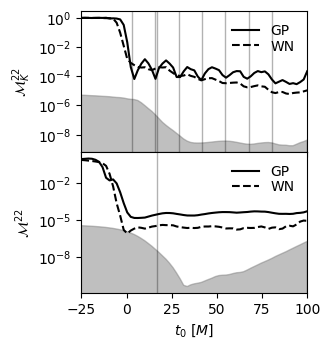

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(fig_width, fig_height*1.7), sharex=True, gridspec_kw={'hspace': 0})
colors = matte_viridis(np.linspace(0, 1, 1))

ax1.axvline(T0_REF, color="k", alpha=0.3, lw=1)
ax1.plot(T0s, weighted_mismatches_GP, label="GP", color='k')
ax1.plot(T0s, weighted_mismatches_WN, label="WN", ls='--', color='k')
ax1.fill_between(T0s, 0, weighted_mismatches_noise, color="grey", alpha=0.5)
ax1.set_xlim(T0s[0], T0s[-1])
ax1.set_ylabel(r"$\mathcal{M}^{22}_K$")
ax1.set_yscale("log")
ax1.legend()
_ = ax1.legend(ncol=1, frameon=False, loc="upper right", labelspacing=0.1)

T_test = np.pi * 2 / qnmfits.qnm.omega(2,2,3,1, sim_main.chif_mag, Mf=sim_main.Mf).real 
for i in np.arange(-1, 6, 1):
    ax1.axvline(16 + i*T_test, color="k", alpha=0.3, lw=1)

ax2.axvline(T0_REF, color="k", alpha=0.3, lw=1)
ax2.plot(T0s, unweighted_mismatches_GP, label="GP", color='k')
ax2.plot(T0s, unweighted_mismatches_WN, label="WN", ls='--', color='k')
ax2.fill_between(T0s, 0, unweighted_mismatches_noise, color="grey", alpha=0.5)
ax2.set_xlim(T0s[0], T0s[-1])
ax2.set_xlabel("$t_0 \ [M]$")
ax2.set_ylabel(r"$\mathcal{M}^{22}$")
ax2.set_yscale("log")
_ = ax2.legend(ncol=1, frameon=False, loc="upper right", labelspacing=0.1)

plt.tight_layout()
plt.show()
fig.savefig("mismatch_osc.pdf", bbox_inches="tight")

# Amplitude Plot

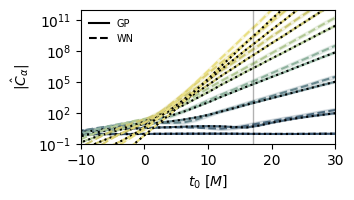

In [ ]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
colors = matte_viridis(np.linspace(0, 1, len(qnm_list)))

for i, qnm in enumerate(qnm_list):
    decay_time = qnmfits.qnm.omega_list([qnm], chif_mag_ref, Mf_ref)[0].imag
    closest_time_index = np.argmin(np.abs(T0s - 0))
    C_tau = np.exp(decay_time * (T0s[closest_time_index] - T0s))
    ax.plot(T0s, amplitudes_GP_percentiles[50][:, i] * C_tau, label=f"{qnm[2]}", color=colors[i])
    ax.plot(T0s, amplitudes_WN_percentiles[50][:, i] * C_tau, linestyle='--', color=colors[i])
    ax.fill_between(
        T0s,
        amplitudes_GP_percentiles[25][:, i] * C_tau,
        amplitudes_GP_percentiles[75][:, i] * C_tau,
        alpha=0.2,
        color=colors[i],
    )
    ax.fill_between(
        T0s,
        amplitudes_WN_percentiles[25][:, i] * C_tau,
        amplitudes_WN_percentiles[75][:, i] * C_tau,
        alpha=0.2,
        color=colors[i],
    )

solid_line = Line2D([0], [0], color="black", linestyle="-")
dashed_line = Line2D([0], [0], color="black", linestyle="--")
color_legend = ax.legend(
    title="$n$", title_fontsize=8, ncol=4, frameon=False, loc="upper center", bbox_to_anchor=(0.5, 1.4), fontsize=7
)
color_legend = ax.legend(
    title="$n$", title_fontsize=8, ncol=1, frameon=False, loc="center right", bbox_to_anchor=(1.25, 0.5), fontsize=7
)
line_legend = ax.legend(
    [solid_line, dashed_line],
    ["GP", "WN"],
    frameon=False,
    loc="upper left",
    ncol=1,
    fontsize=7
)
ax.add_artist(color_legend) 

ax.axvline(T0_REF, color="k", alpha=0.3, lw=1)
ax.set_xlim(-10, 30)
ax.set_ylim(0.1, 1e12)
ax.set_xlabel("$t_0 \ [M]$")
ax.set_ylabel(r"$|\hat{C}_{\alpha}|$")
ax.set_yscale("log")
 
plt.tight_layout()
plt.subplots_adjust(right=1) 
plt.show()

fig.savefig("test_percentiles.pdf", bbox_inches="tight", bbox_extra_artists=[color_legend])

# Amplitude Plot Variation

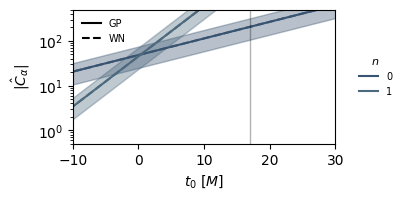

FileNotFoundError: [Errno 2] No such file or directory: 'paper_figs/amplitudes.pdf'

In [23]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
colors = matte_viridis(np.linspace(0, 1, len(qnm_list)))

for i, qnm in enumerate(qnm_list):
    if i <= 1:
        decay_time = qnmfits.qnm.omega_list([qnm], chif_mag_ref, Mf_ref)[0].imag
        closest_time_index = np.argmin(np.abs(T0s - 0))
        C_tau = np.exp(decay_time * (T0s[closest_time_index] - T0s))
        ax.plot(T0s, amplitudes_GP_50_percentiles[:, i] * C_tau, label=f"{qnm[2]}", color=colors[i])
        ax.plot(T0s, amplitudes_WN_50_percentiles[:, i] * C_tau, linestyle='--', color=colors[i])
        ax.fill_between(
            T0s,
            amplitudes_GP_25_percentiles[:, i] * C_tau,
            amplitudes_GP_75_percentiles[:, i] * C_tau,
            alpha=0.2,
            color=colors[i],
        )
        ax.fill_between(
            T0s,
            amplitudes_WN_25_percentiles[:, i] * C_tau,
            amplitudes_WN_75_percentiles[:, i] * C_tau,
            alpha=0.2,
            color=colors[i],
        )

solid_line = Line2D([0], [0], color="black", linestyle="-")
dashed_line = Line2D([0], [0], color="black", linestyle="--")
#color_legend = ax.legend(
#    title="$n$", title_fontsize=8, ncol=4, frameon=False, loc="upper center", bbox_to_anchor=(0.5, 1.4), fontsize=7
#)
color_legend = ax.legend(
    title="$n$", title_fontsize=8, ncol=1, frameon=False, loc="center right", bbox_to_anchor=(1.25, 0.5), fontsize=7
)
line_legend = ax.legend(
    [solid_line, dashed_line],
    ["GP", "WN"],
    frameon=False,
    loc="upper left",
    ncol=1,
    fontsize=7
)
ax.add_artist(color_legend) 

ax.axvline(T0_REF, color="k", alpha=0.3, lw=1)
ax.set_xlim(-10, 30)
ax.set_ylim(0.5, 5e2)
ax.set_xlabel("$t_0 \ [M]$")
ax.set_ylabel(r"$|\hat{C}_{\alpha}|$")
ax.set_yscale("log")
 
plt.tight_layout()
plt.subplots_adjust(right=1) 
plt.show()

fig.savefig("paper_figs/amplitudes.pdf", bbox_inches="tight", bbox_extra_artists=[color_legend])

# Significance Plot

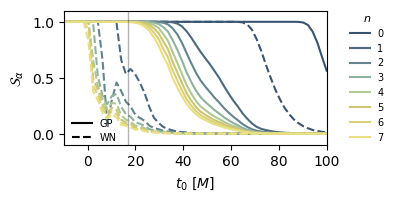

In [ ]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
colors = matte_viridis(np.linspace(0, 1, len(qnm_list)))

for i, qnm in enumerate(qnm_list):
    ax.plot(T0s, significances_GP[:, i], label=f"{qnm[2]}", color=colors[i])
    ax.plot(T0s, significances_WN[:, i], linestyle='--', color=colors[i])

solid_line = Line2D([0], [0], color="black", linestyle="-")
dashed_line = Line2D([0], [0], color="black", linestyle="--")
color_legend = ax.legend(
    title="$n$", title_fontsize=8, ncol=1, frameon=False, loc="center right", bbox_to_anchor=(1.23, 0.5), fontsize=7
)
line_legend = ax.legend(
    [solid_line, dashed_line],
    ["GP", "WN"],
    frameon=False,
    loc="lower left",
    ncol=1,
    fontsize=7,
    bbox_to_anchor=(0, -0.05),
)

ax.add_artist(color_legend) 

ax.axvline(T0_REF, color="k", alpha=0.3, lw=1)
ax.set_xlabel("$t_0 \ [M]$")
ax.set_ylabel(r"$\mathcal{S}_{\alpha}$")
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(-10, T0s[-1])
#ax.set_yscale("log")

plt.tight_layout()
plt.subplots_adjust(right=1) 
plt.show()

# TODO: Do logscale version 

fig.savefig("paper_figs/significances.pdf", bbox_inches="tight")

# Corner Plots

In [ ]:
fit_LS = qnmfits.multimode_ringdown_fit(
                    sim_main.times,
                    sim_main.h,
                    qnm_list,
                    Mf_t0,
                    chif_t0,
                    T0_REF,
                    T=T,
                    spherical_modes=spherical_modes,
                )

fit_WN = qnm_BGP_fit(
            sim_main.times,
            sim_main.h,
            qnm_list,
            Mf_ref,
            chif_mag_ref,
            T0_REF,
            tuned_param_dict_wn, 
            kernel_s,
            t0_method="geq",
            T=T,
            spherical_modes=spherical_modes,
            include_chif=INCLUDE_CHIF,
            include_Mf=INCLUDE_MF,
        )

fit_GP = qnm_BGP_fit(
            sim_main.times,
            sim_main.h,
            qnm_list,
            Mf_ref,
            chif_mag_ref,
            T0_REF,
            tuned_param_dict_main,
            kernel_main,
            t0_method="geq",
            T=T,
            spherical_modes=spherical_modes,
            include_chif=INCLUDE_CHIF,
            include_Mf=INCLUDE_MF,
        )
    

In [ ]:
ref_params = []
for re_c, im_c in zip(np.real(fit_LS["C"]), np.imag(fit_LS["C"])):
    ref_params.append(re_c)
    ref_params.append(im_c)

In [ ]:
colors = matte_viridis(np.linspace(0, 1, len(qnm_list)))
to_hex(colors[3]) 

'#8fb29e'

In [ ]:
fundamental_color_WN = to_hex('#395470')
fundamental_color_GP = to_hex('#395471')

overtone_color_WN = to_hex('#65858c')
overtone_color_GP = to_hex('#65858d')

In [ ]:
param_list = [qnm for qnm in qnm_list for _ in range(2)] + ["chif"] + ["Mf"]  

samples_WN  = scipy.stats.multivariate_normal(
    fit_WN['mean'], fit_WN['covariance'], allow_singular=True
).rvs(size=10000)

samples_GP = scipy.stats.multivariate_normal(
    fit_GP['mean'], fit_GP['covariance'], allow_singular=True
).rvs(size=10000)

In [ ]:
num_amplitude_params = len(qnm_list) * 2

samples_re_WN = samples_WN[:, :num_amplitude_params:2]
samples_im_WN = samples_WN[:, 1:num_amplitude_params:2]
samples_abs_WN = np.sqrt(samples_re_WN**2 + samples_im_WN**2)

samples_re_GP = samples_GP[:, :num_amplitude_params:2]  
samples_im_GP = samples_GP[:, 1:num_amplitude_params:2]  
samples_abs_GP = np.sqrt(samples_re_GP**2 + samples_im_GP**2)  

log_amplitudes_WN = np.log(samples_abs_WN) 
samples_weights_WN = np.exp(-np.sum(log_amplitudes_WN, axis=1)) 

log_amplitudes_GP = np.log(samples_abs_GP)
samples_weights_GP = np.exp(-np.sum(log_amplitudes_GP, axis=1))

### Corner + KDE Fundamental

In [ ]:
parameter_choice = [(2,2,0,1)]

labels = [
    rf"$\mathrm{{Re}}(C_{{({param[0]},{param[1]},{param[2]},+)}})$" if i % 2 == 0 else rf"$\mathrm{{Im}}(C_{{({param[0]},{param[1]},{param[2]},+)}})$"
    for param in parameter_choice
    for i in range(2)
]

abs_indices_fundamental = [i for i, param in enumerate(qnm_list) if param in parameter_choice]
indices_fundamental = [i for i, param in enumerate(param_list) if param in parameter_choice]

In [ ]:
samples_abs_fundamental_WN = samples_abs_WN[:, abs_indices_fundamental] 
samples_abs_fundamental_GP = samples_abs_GP[:, abs_indices_fundamental] 

samples_fundamental_WN = samples_WN[:, indices_fundamental] 
samples_fundamental_GP = samples_GP[:, indices_fundamental]

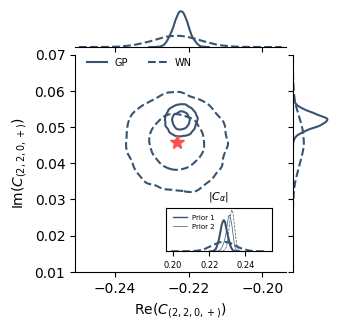

In [ ]:
df_samples_fundamental_WN = pd.DataFrame(samples_fundamental_WN, columns=labels)
df_samples_fundamental_GP = pd.DataFrame(samples_fundamental_GP, columns=labels)

df_samples_fundamental_WN['Dataset'] = 'WN'
df_samples_fundamental_GP['Dataset'] = 'GP'

# Create the jointplot
g = sns.jointplot(
    data=df_samples_fundamental_GP,
    x=labels[0],
    y=labels[1],
    hue="Dataset",
    kind="kde",  
    palette=[fundamental_color_GP],
    marginal_kws={"fill": False},
    height=fig_width,  
    levels = [0.1, 0.5]
)

sns.kdeplot(df_samples_fundamental_WN[labels[0]], ax=g.ax_marg_x, color=fundamental_color_WN, linestyle='--', fill=False)
sns.kdeplot(y = df_samples_fundamental_WN[labels[1]], ax=g.ax_marg_y, color=fundamental_color_WN, linestyle='--', fill=False)
sns.kdeplot(x = df_samples_fundamental_WN[labels[0]], y = df_samples_fundamental_WN[labels[1]], ax=g.ax_joint, color=fundamental_color_WN, fill=False, levels=[0.1, 0.5])

g.ax_joint.legend_.remove()

g.ax_joint.plot(ref_params[indices_fundamental[0]], ref_params[indices_fundamental[1]], "*", color="#fc5151", markersize=10)

# Get dashed lines for the WN contours 
for collection in g.ax_joint.collections:
    color = None
    if collection.get_edgecolor().size:
        color = to_hex(collection.get_edgecolor()[0])
    elif collection.get_facecolor().size:
        color = to_hex(collection.get_facecolor()[0])
    if color == fundamental_color_WN:
        collection.set_linestyle('--')  # Set linestyle to dashed for WN

# Add vertical and horizontal dotted lines at the truth values
#g.ax_joint.axvline(0, color="black", linestyle=":", linewidth=1)
#g.ax_joint.axhline(0, color="black", linestyle=":", linewidth=1)

ax_inset = inset_axes(
    g.ax_joint, 
    width="50%",  # Width of the inset as a percentage of the parent axis
    height="20%",  # Height of the inset as a percentage of the parent axis
    loc="lower right",  # Location of the inset
    borderpad=1,  # Padding between the inset and the parent axis
    bbox_to_anchor=(0, 0.03, 1, 1),  # Shift the inset slightly up
    bbox_transform=g.ax_joint.transAxes
)

df_samples_abs_fundamental_WN = pd.DataFrame({'Amplitude': samples_abs_fundamental_WN.flatten(), 'Dataset': 'WN'})
df_samples_abs_fundamental_GP = pd.DataFrame({'Amplitude': samples_abs_fundamental_GP.flatten(), 'Dataset': 'GP'})

df_samples_abs_fundamental_WN['Weight'] = samples_weights_WN
df_samples_abs_fundamental_GP['Weight'] = samples_weights_GP

sns.kdeplot(
    data=df_samples_abs_fundamental_GP, 
    x='Amplitude', 
    color=fundamental_color_GP, 
    label="GP (Prior 1)", 
    ax=ax_inset
)
sns.kdeplot(
    data=df_samples_abs_fundamental_WN, 
    x='Amplitude', 
    color=fundamental_color_WN, 
    linestyle='--', 
    label="WN (Prior 1)", 
    ax=ax_inset
)

sns.kdeplot(
    data=df_samples_abs_fundamental_GP, 
    x='Amplitude', 
    color=fundamental_color_GP, 
    label="GP (Prior 2)", 
    linewidth=0.5,
    weights='Weight', 
    ax=ax_inset
)
sns.kdeplot(
    data=df_samples_abs_fundamental_WN, 
    x='Amplitude', 
    color=fundamental_color_WN, 
    label="WN (Prior 2)", 
    linestyle='--', 
    linewidth=0.5,
    weights='Weight', 
    ax=ax_inset
)

ax_inset.set_title(r"$|C_{\alpha}|$", fontsize=8)
#ax_inset.set_xlim(0.19, 0.23)
#ax_inset.set_ylim(0.0, 300)
ax_inset.set_ylabel("")
ax_inset.set_xlabel("")
ax_inset.set_yticklabels([])
ax_inset.yaxis.set_ticks([])
ax_inset.tick_params(axis='both', which='major', labelsize=6)

line_styles_inset = [Line2D([0], [0], color=fundamental_color_GP, linewidth=1, label='Prior 1'),
               Line2D([0], [0], color=fundamental_color_WN, linewidth=0.5, label='Prior 2')]

ax_inset.legend(handles=line_styles_inset, loc='upper left', frameon=False, ncol=1, fontsize=5)

#g.ax_joint.set_xlim(-0.175, -0.135)
g.ax_joint.set_ylim(0.01, 0.07)

line_styles = [Line2D([0], [0], color=fundamental_color_WN, linestyle='-', label='GP'),
               Line2D([0], [0], color=fundamental_color_WN, linestyle='--', label='WN')]

g.figure.legend(handles=line_styles, loc='upper left', frameon=False, bbox_to_anchor=(0.22, 0.84), ncol=2, fontsize=7)

#g.figure.savefig("paper_figs/fundamental_corner.pdf", bbox_inches="tight")

# Show the plot
plt.show()

In [ ]:
parameter_choice = [(2,2,2,1)]

labels = [
    rf"$\mathrm{{Re}}(C_{{({param[0]},{param[1]},{param[2]},+)}})$" if i % 2 == 0 else rf"$\mathrm{{Im}}(C_{{({param[0]},{param[1]},{param[2]},+)}})$"
    for param in parameter_choice
    for i in range(2)
]

abs_indices_overtone = [i for i, param in enumerate(qnm_list) if param in parameter_choice]
indices_overtone = [i for i, param in enumerate(param_list) if param in parameter_choice]

In [ ]:
samples_abs_overtone_WN = samples_abs_WN[:, abs_indices_overtone] 
samples_abs_overtone_GP = samples_abs_GP[:, abs_indices_overtone] 

samples_overtone_WN = samples_WN[:, indices_overtone] 
samples_overtone_GP = samples_GP[:, indices_overtone]

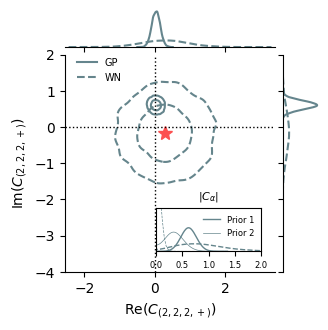

In [ ]:
df_samples_overtone_WN = pd.DataFrame(samples_overtone_WN, columns=labels)
df_samples_overtone_GP = pd.DataFrame(samples_overtone_GP, columns=labels)

df_samples_overtone_WN['Dataset'] = 'WN'
df_samples_overtone_GP['Dataset'] = 'GP'

# Create the jointplot
g = sns.jointplot(
    data=df_samples_overtone_GP,
    x=labels[0],
    y=labels[1],
    palette=[overtone_color_GP],
    hue="Dataset",
    kind="kde",  
    marginal_kws={"fill": False},
    height=fig_width,  
    levels = [0.1, 0.5]
)

sns.kdeplot(df_samples_overtone_WN[labels[0]], ax=g.ax_marg_x, color=overtone_color_WN, linestyle='--', fill=False)
sns.kdeplot(y = df_samples_overtone_WN[labels[1]], ax=g.ax_marg_y, color=overtone_color_WN, linestyle='--', fill=False)
sns.kdeplot(x = df_samples_overtone_WN[labels[0]], y = df_samples_overtone_WN[labels[1]], ax=g.ax_joint, color=overtone_color_WN, fill=False, levels=[0.1, 0.5])

g.ax_joint.legend_.remove()
g.ax_joint.plot(ref_params[indices_overtone[0]], ref_params[indices_overtone[1]], "*", color="#fc5151", markersize=10)

# Get dashed lines for the WN contours 
for collection in g.ax_joint.collections:
    color = None
    if collection.get_edgecolor().size:
        color = to_hex(collection.get_edgecolor()[0])
    elif collection.get_facecolor().size:
        color = to_hex(collection.get_facecolor()[0])
    if color == overtone_color_WN:
        collection.set_linestyle('--')  # Set linestyle to dashed for WN

g.ax_joint.axvline(0, color="black", linestyle=":", linewidth=1)
g.ax_joint.axhline(0, color="black", linestyle=":", linewidth=1)

ax_inset = inset_axes(
    g.ax_joint, 
    width="50%",  # Width of the inset as a percentage of the parent axis
    height="20%",  # Height of the inset as a percentage of the parent axis
    loc="lower right",  # Location of the inset
    borderpad=1,  # Padding between the inset and the parent axis
    bbox_to_anchor=(0, 0.03, 1, 1),  # Shift the inset slightly up
    bbox_transform=g.ax_joint.transAxes
)

df_samples_abs_overtone_WN = pd.DataFrame({'Amplitude': np.hstack((samples_abs_overtone_WN.flatten(), -samples_abs_overtone_WN.flatten())), 'Dataset': 'WN'})
df_samples_abs_overtone_GP = pd.DataFrame({'Amplitude': np.hstack((samples_abs_overtone_GP.flatten(), -samples_abs_overtone_GP.flatten())), 'Dataset': 'GP'})

df_samples_abs_overtone_WN['Weight'] = np.hstack((samples_weights_WN, samples_weights_WN))
df_samples_abs_overtone_GP['Weight'] = np.hstack((samples_weights_GP, samples_weights_GP))

sns.kdeplot(
    data=df_samples_abs_overtone_GP, 
    x='Amplitude', 
    color=overtone_color_GP, 
    linewidth=1,
    label="GP (Prior 1)", 
    ax=ax_inset
)
sns.kdeplot(
    data=df_samples_abs_overtone_WN, 
    x='Amplitude',  
    color=overtone_color_WN, 
    linestyle='--', 
    linewidth=1,
    label="WN (Prior 1)", 
    ax=ax_inset
)

sns.kdeplot(
    data=df_samples_abs_overtone_GP, 
    x='Amplitude', 
    color=overtone_color_GP, 
    label="GP (Prior 2)", 
    linewidth=0.5,
    weights="Weight", 
    ax=ax_inset,
)
sns.kdeplot(
    data=df_samples_abs_overtone_WN, 
    x='Amplitude', 
    color=overtone_color_WN, 
    label="WN (Prior 2)", 
    linestyle='--', 
    linewidth=0.5,
    weights="Weight",
    ax=ax_inset,
)

ax_inset.set_title(r"$|C_{\alpha}|$", fontsize=8)
ax_inset.set_xlim(0, 2)
ax_inset.set_ylim(0, 2.5)
ax_inset.set_ylabel("")
ax_inset.set_xlabel("")
ax_inset.set_yticklabels([])
ax_inset.yaxis.set_ticks([])
ax_inset.tick_params(axis='both', which='major', labelsize=6)

line_styles_inset = [Line2D([0], [0], color=overtone_color_GP, linewidth=1, label='Prior 1'),
               Line2D([0], [0], color=overtone_color_WN, linewidth=0.5, label='Prior 2')]

ax_inset.legend(handles=line_styles_inset, loc='upper right', frameon=False, ncol=1, fontsize=6)

#g.ax_joint.set_xlim(-0.175, -0.135)
g.ax_joint.set_ylim(-4, 2)

line_styles = [Line2D([0], [0], color=overtone_color_GP, linestyle='-', label='GP'),
               Line2D([0], [0], color=overtone_color_WN, linestyle='--', label='WN')]

g.figure.legend(handles=line_styles, loc='upper left', frameon=False, bbox_to_anchor=(0.22, 0.84), ncol=1, fontsize=7)

#g.figure.savefig("paper_figs/overtone_corner.pdf", bbox_inches="tight")

# Show the plot
plt.show()

# Mass and spin 

In [ ]:
parameter_choice = ["chif", "Mf"]

indices_Chif_M = [i for i, param in enumerate(param_list) if param in parameter_choice]
labels_Chif_M = parameter_choice

In [ ]:
samples_Chif_M_WN = samples_WN[:, indices_Chif_M] 
samples_Chif_M_GP = samples_GP[:, indices_Chif_M]

/tmp/ipykernel_2366773/1321020238.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.ax_joint.legend(loc="upper right", frameon=False)


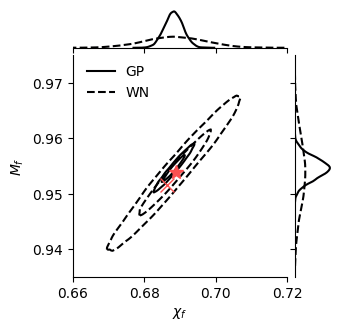

In [ ]:
df_wn_Chif_M = pd.DataFrame(samples_Chif_M_WN, columns=labels_Chif_M)
df_main_Chif_M = pd.DataFrame(samples_Chif_M_GP, columns=labels_Chif_M)

df_wn_Chif_M['Dataset'] = 'WN'
df_main_Chif_M['Dataset'] = 'GP'

# Create the jointplot
g = sns.jointplot(
    data=df_main_Chif_M,
    x="chif",
    y="Mf",
    hue="Dataset",
    kind="kde",  
    palette=['#000002'],
    marginal_kws={"fill": False},
    height=fig_width,  
    levels = [0.1, 0.5],
)

sns.kdeplot(df_wn_Chif_M[labels_Chif_M[0]], ax=g.ax_marg_x, color='#000001', linestyle='--', fill=False)
sns.kdeplot(y = df_wn_Chif_M[labels_Chif_M[1]], ax=g.ax_marg_y, color='#000001', linestyle='--', fill=False)
sns.kdeplot(x = df_wn_Chif_M[labels_Chif_M[0]], y = df_wn_Chif_M[labels_Chif_M[1]], ax=g.ax_joint, color='#000001', fill=False, levels=[0.1, 0.5])

# --- Adjust the central plot (ax_joint) KDEs ---
for collection in g.ax_joint.collections:
    color = None
    if collection.get_edgecolor().size:
        color = to_hex(collection.get_edgecolor()[0])
    elif collection.get_facecolor().size:
        color = to_hex(collection.get_facecolor()[0])

    if color == '#000001':
        collection.set_linestyle('--')  # Set linestyle to dashed for WN

# Add vertical and horizontal dotted lines at the truth values
g.ax_joint.plot(chif_t0, Mf_t0, "*", color="#fc5151", markersize=10)
g.ax_joint.plot(chif_mag_ref, Mf_ref, "x", color="#fc5151", markersize=10)

# Add legend for the truth values
g.ax_joint.legend(loc="upper right", frameon=False)

# Add labels
g.set_axis_labels(r"$\chi_f$", r"$M_f$")

g.ax_joint.set_xlim(0.66, 0.72)
g.ax_joint.set_ylim(0.935, 0.975)

line_styles = [Line2D([0], [0], color='#000001', linestyle='-', label='GP'),
               Line2D([0], [0], color='#000001', linestyle='--', label='WN')]

g.figure.legend(handles=line_styles, loc='upper left', frameon=False, bbox_to_anchor=(0.2, 0.83))

#g.figure.savefig("paper_figs/mass_spin_corner.pdf", bbox_inches="tight")

# Show the plot
plt.show()

## Full mass and spin - no longer in use

In [ ]:
"""
df_main = pd.DataFrame(samples_main, columns=labels)
df_wn = pd.DataFrame(samples_wn, columns=labels)

df_main['Dataset'] = 'Main'
df_wn['Dataset'] = 'WN'
df_combined = pd.concat([df_main, df_wn])

truths = [ref_params[i] for i in indices]
pairplot = sns.pairplot(
    df_combined,  # Filter for WN dataset
    kind='kde',
    hue='Dataset',
    diag_kind='kde',
    palette={'WN': '#395470', 'Main': '#395471'},
    plot_kws={'alpha': 1}, 
    diag_kws={'fill': False},  
    corner=True,
    height=fig_width / 2,  
    aspect=1,
)

# A ridiculous workaround to get dashed lines 
# TODO: Simplify this 

wn_color = to_hex('#395470')  
main_color = to_hex('#395471') 

lss = ['dashed', '-']

diag = pairplot.diag_axes
for ax in diag:
    for line, ls in zip(ax.lines, lss):
        line.set_linestyle(ls)
        line.set_linewidth(0.9)

for i, ax in enumerate(pairplot.axes.flat):
    if ax is None:
        continue

    row, col = divmod(i, len(labels))
    if row < col:
        continue  

    for collection in ax.collections:
        if collection.get_edgecolor().size:
            color = to_hex(collection.get_edgecolor()[0])
        elif collection.get_facecolor().size:
            color = to_hex(collection.get_facecolor()[0])
        else:
            continue

        collection.set_linewidth(0.9)

        if color == wn_color:
            collection.set_linestyle('--')

    # Reference lines (truths)
    ax.axvline(truths[col], color='black', linestyle=':', linewidth=1)
    if row != col:
        ax.axhline(truths[row], color='black', linestyle=':', linewidth=1)

pairplot._legend.remove()

# Add a legend describing the two linestyles
line_styles = [Line2D([0], [0], color=wn_color, linestyle='-', label='GP'),
               Line2D([0], [0], color=wn_color, linestyle='--', label='WN')]

pairplot.figure.legend(handles=line_styles, loc='center', bbox_to_anchor=(0.6, 0.6), frameon=False)

pairplot.savefig("paper_figs/amplitude_corner.pdf", bbox_inches="tight")
""" 


'\ndf_main = pd.DataFrame(samples_main, columns=labels)\ndf_wn = pd.DataFrame(samples_wn, columns=labels)\n\ndf_main[\'Dataset\'] = \'Main\'\ndf_wn[\'Dataset\'] = \'WN\'\ndf_combined = pd.concat([df_main, df_wn])\n\ntruths = [ref_params[i] for i in indices]\npairplot = sns.pairplot(\n    df_combined,  # Filter for WN dataset\n    kind=\'kde\',\n    hue=\'Dataset\',\n    diag_kind=\'kde\',\n    palette={\'WN\': \'#395470\', \'Main\': \'#395471\'},\n    plot_kws={\'alpha\': 1}, \n    diag_kws={\'fill\': False},  \n    corner=True,\n    height=fig_width / 2,  \n    aspect=1,\n)\n\n# A ridiculous workaround to get dashed lines \n# TODO: Simplify this \n\nwn_color = to_hex(\'#395470\')  \nmain_color = to_hex(\'#395471\') \n\nlss = [\'dashed\', \'-\']\n\ndiag = pairplot.diag_axes\nfor ax in diag:\n    for line, ls in zip(ax.lines, lss):\n        line.set_linestyle(ls)\n        line.set_linewidth(0.9)\n\nfor i, ax in enumerate(pairplot.axes.flat):\n    if ax is None:\n        continue\n\n    